# Step 0

Prepare Google Colab notebook

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Install and Import Required Dependencies

In [2]:
!pip install tensorflow tensorflow-hub tensorflow-addons matplotlib scikit-learn seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 5.1 MB/s eta 0:00:00


#Step 1: Data Preprocessing

## Data Preparation

In [ ]:
import os
import shutil
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import KFold
import json

import cv2
import numpy as np

Cropping images to remove unnecessary black background

In [ ]:
def process_image(image_path, output_path, padding=10):
    # Load the image
    image = cv2.imread(image_path)

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply thresholding to create a binary mask
    _, binary_mask = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        print(f"No contours found for image: {image_path}")
        return

    # Get the bounding box of the largest contour
    x, y, w, h = cv2.boundingRect(contours[0])

    # Add padding to the bounding box
    x = max(0, x - padding)
    y = max(0, y - padding)
    w = min(w + 2 * padding, image.shape[1] - x)
    h = min(h + 2 * padding, image.shape[0] - y)

    # Crop the image using the bounding box
    cropped_image = image[y:y+h, x:x+w]

    # Save the result
    cv2.imwrite(output_path, image)

# Function to process all images in a folder
def process_all_images(input_folder, output_folder):
    for root, _, files in os.walk(input_folder):
        for filename in files:
            if filename.lower().endswith('.jpg'):
                input_path = os.path.join(root, filename)
                relative_path = os.path.relpath(root, input_folder)
                output_dir = os.path.join(output_folder, relative_path)

                if not os.path.exists(output_dir):
                    os.makedirs(output_dir)

                output_path = os.path.join(output_dir, filename)
                process_image(input_path, output_path)
                print(f"Processed {filename} in {relative_path}")

# Define the input and output directories
input_folder = '/content/drive/MyDrive/CSC3009Project/dataset_13'
output_folder = '/content/drive/MyDrive/CSC3009Project/processed_dataset_13'

# Process all images in the folder
process_all_images(input_folder, output_folder)

Processed Tr-pi_0196.jpg in pituitary
Processed Tr-pi_0368.jpg in pituitary
Processed Tr-pi_0367.jpg in pituitary
Processed Tr-pi_0480.jpg in pituitary
Processed Tr-pi_0335.jpg in pituitary
Processed Tr-pi_0039(2).jpg in pituitary
Processed Tr-pi_0020.jpg in pituitary
Processed Tr-pi_0439.jpg in pituitary
Processed Te-pi_0066.jpg in pituitary
Processed Tr-pi_0207(2).jpg in pituitary
Processed Te-pi_0129.jpg in pituitary
Processed Tr-pi_0321.jpg in pituitary
Processed Tr-pi_0482.jpg in pituitary
Processed Tr-pi_0292.jpg in pituitary
Processed Tr-pi_0254.jpg in pituitary
Processed Te-pi_0205.jpg in pituitary
Processed Tr-pi_0316.jpg in pituitary
Processed Tr-pi_0255.jpg in pituitary
Processed Tr-pi_0026.jpg in pituitary
Processed Te-pi_0062.jpg in pituitary
Processed Te-pi_0168.jpg in pituitary
Processed Tr-pi_0445.jpg in pituitary
Processed Tr-pi_0185.jpg in pituitary
Processed Tr-pi_0246.jpg in pituitary
Processed Tr-pi_0039(1).jpg in pituitary
Processed Tr-pi_0419.jpg in pituitary
Pro

Load the dataset and split it into training and validation sets. We will apply data augmentations to the training set.

In [ ]:
# Define a transform that only converts the image to a tensor
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load your dataset
dataset = ImageFolder(root='/content/drive/MyDrive/CSC3009Project/processed_dataset_13', transform=transform)

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=4)

def compute_mean_std(dataloader):
    mean = 0.
    std = 0.
    n_samples = 0.

    for data in dataloader:
        images, _ = data
        batch_samples = images.size(0)  # Batch size (the last batch can have smaller size)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        n_samples += batch_samples

    mean /= n_samples
    std /= n_samples

    return mean, std

mean, std = compute_mean_std(dataloader)
print('Mean:', mean)
print('Std:', std)

mean_std = {
    'mean': mean.tolist(),
    'std': std.tolist()
}

# Save to a JSON file
with open('mean_std.json', 'w') as f:
    json.dump(mean_std, f)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Mean: tensor([0.1845, 0.1845, 0.1845])
Std: tensor([0.1799, 0.1799, 0.1799])


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])

# Define k-fold cross-validation
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Create directories for storing the k-fold datasets
base_dir = '/content/drive/MyDrive/CSC3009Project/dataset_kfold'
os.makedirs(base_dir, exist_ok=True)

for fold, (train_indices, val_indices) in enumerate(kf.split(dataset)):
    # Create directories for the current fold
    fold_dir = os.path.join(base_dir, f'fold_{fold}')
    train_dir = os.path.join(fold_dir, 'train')
    val_dir = os.path.join(fold_dir, 'val')

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    # Create subdirectories for each class
    classes = dataset.classes
    for class_name in classes:
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

    # Helper function to copy files
    def copy_files(indices, root_dir):
        for idx in indices:
            img_path, class_idx = dataset.samples[idx]
            class_name = dataset.classes[class_idx]
            dest_dir = os.path.join(root_dir, class_name)
            shutil.copy(img_path, dest_dir)

    # Copy training and validation images to respective directories
    copy_files(train_indices, train_dir)
    copy_files(val_indices, val_dir)

    # Create subsets for training and validation
    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)

    # Data loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

    print(f'Datasets for fold {fold} are saved in the directory')

Datasets for fold 0 are saved in the directory
Datasets for fold 1 are saved in the directory
Datasets for fold 2 are saved in the directory
Datasets for fold 3 are saved in the directory
Datasets for fold 4 are saved in the directory


##Data Visualization

Load the dataset and split it into training and validation sets. We will apply data augmentations to the training set.

Visualizing the data ensures a balanced distribution of categories in the training set, which is crucial for preventing model biases and enhancing generalization, ultimately leading to improved performance in accurately categorizing new data.

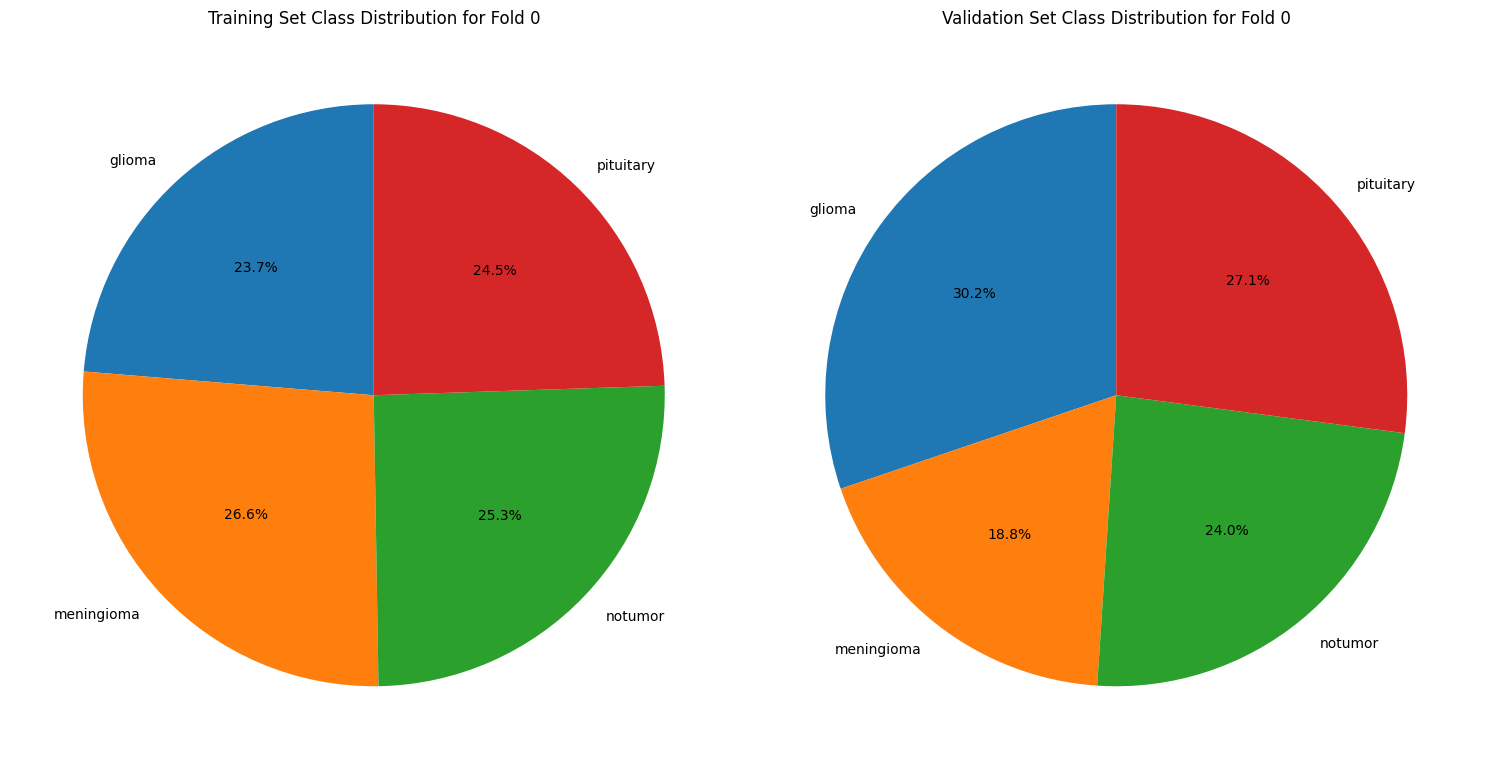

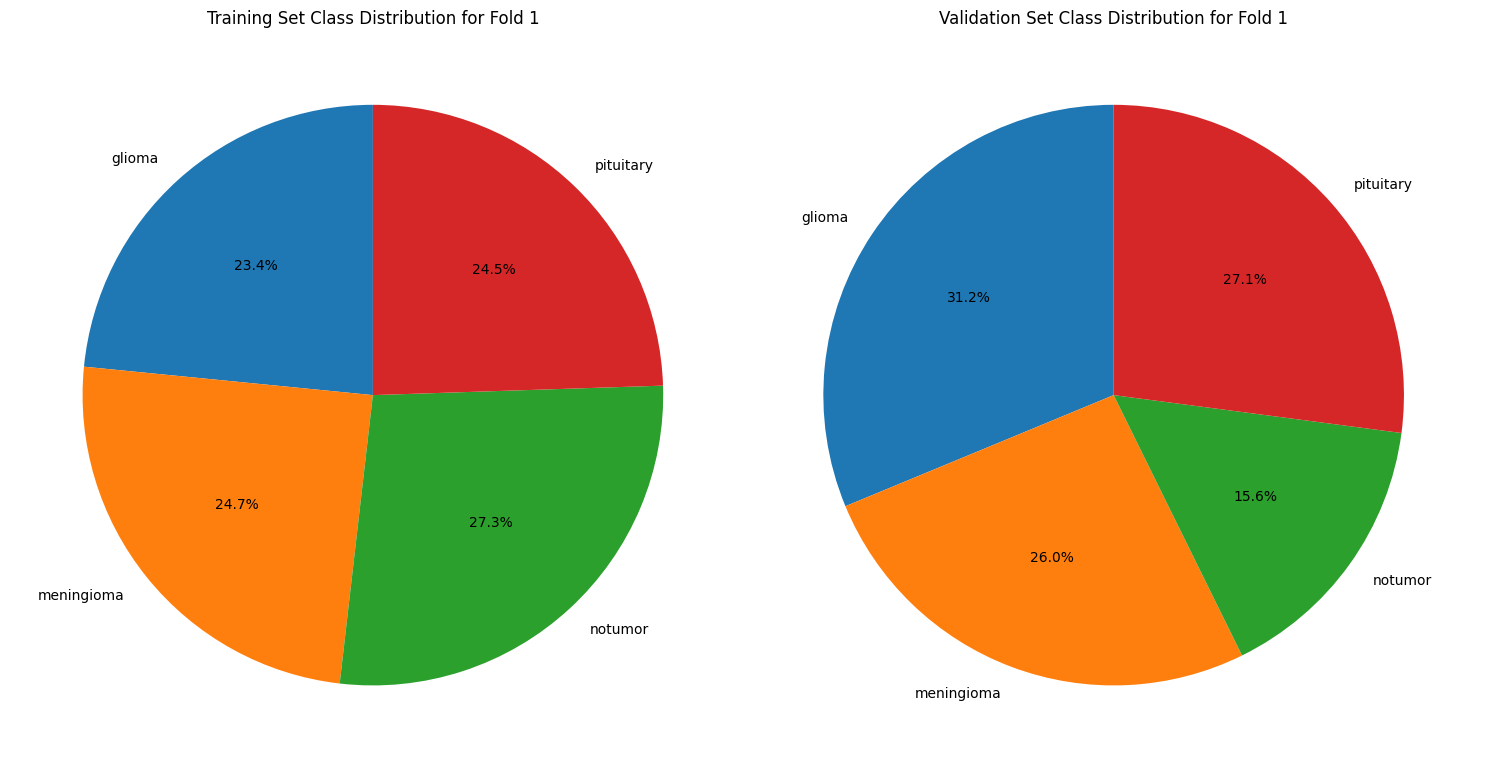

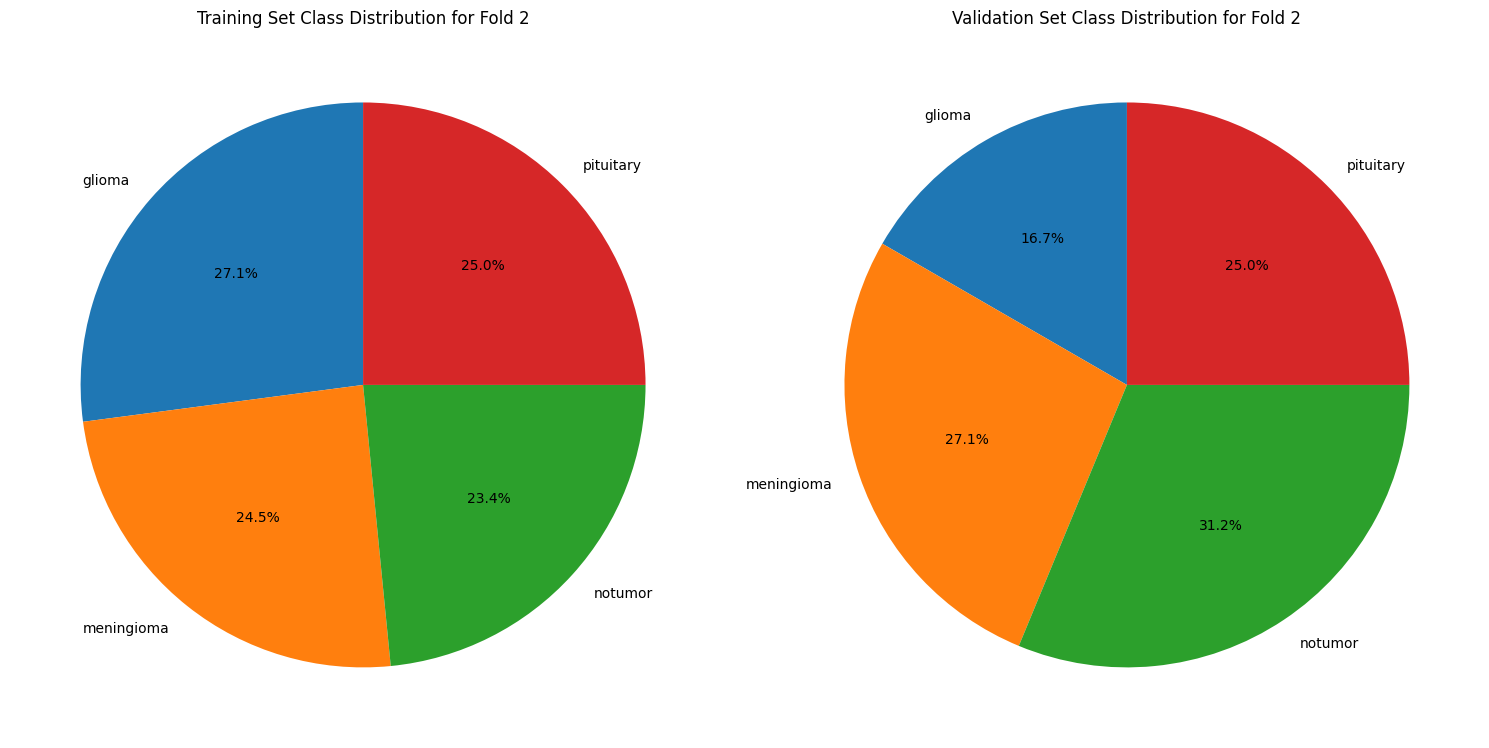

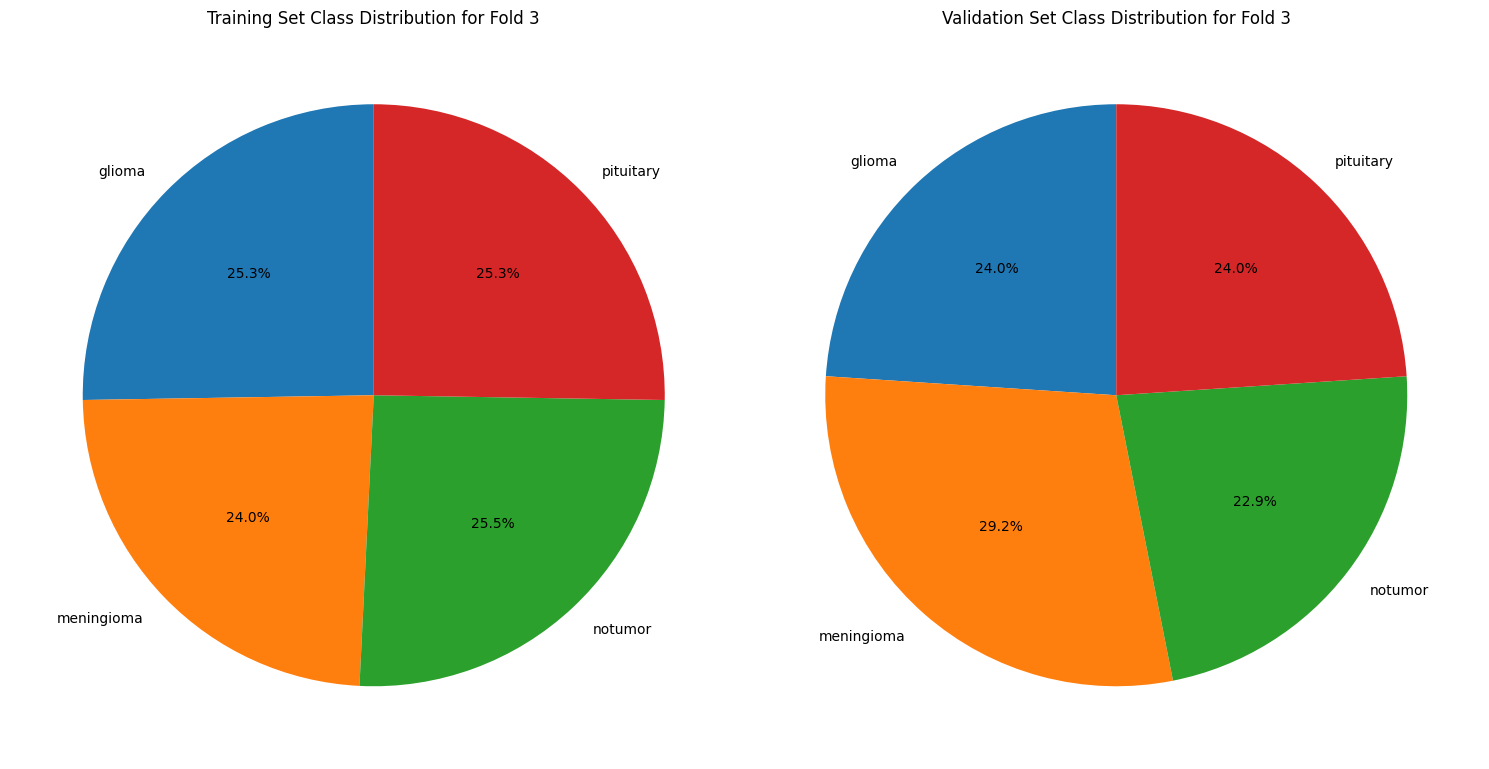

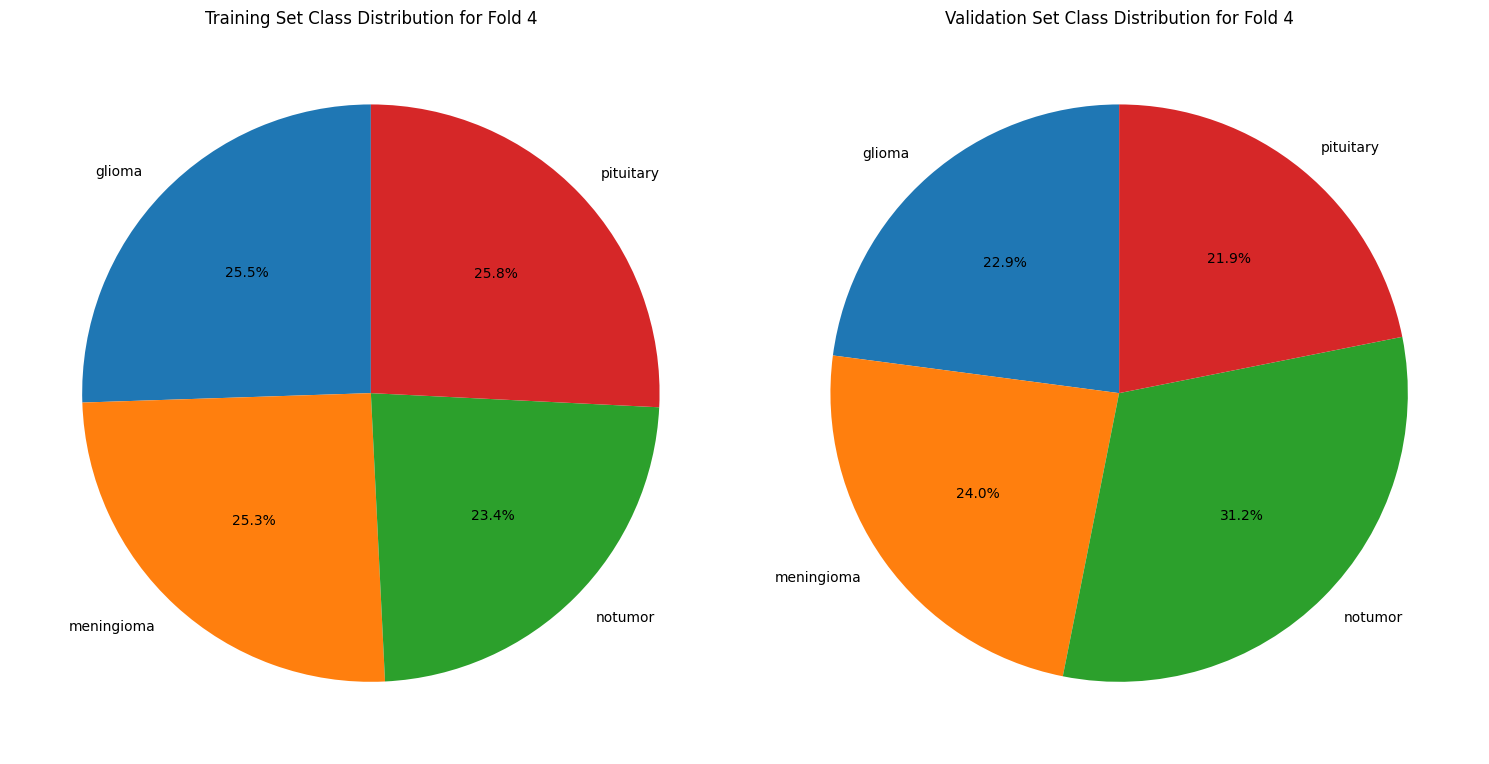

In [ ]:
# Define the function to plot class distribution
def plot_class_distribution(train_class_counts, val_class_counts, class_names, fold):
    fig, ax = plt.subplots(1, 2, figsize=(15, 8))

    ax[0].pie(train_class_counts, labels=class_names, autopct='%1.1f%%', startangle=90)
    ax[0].set_title(f'Training Set Class Distribution for Fold {fold}')

    ax[1].pie(val_class_counts, labels=class_names, autopct='%1.1f%%', startangle=90)
    ax[1].set_title(f'Validation Set Class Distribution for Fold {fold}')

    plt.tight_layout()
    plt.show()

# Base directory containing the k-fold datasets
base_dir = '/content/drive/MyDrive/CSC3009Project/dataset_kfold'

# Loop through each fold directory
for fold in range(5):
    fold_dir = os.path.join(base_dir, f'fold_{fold}')
    train_dir = os.path.join(fold_dir, 'train')
    val_dir = os.path.join(fold_dir, 'val')

    # Load the datasets
    train_dataset = ImageFolder(root=train_dir)
    val_dataset = ImageFolder(root=val_dir)

    # Get the labels from the datasets
    train_labels = [label for _, label in train_dataset.samples]
    val_labels = [label for _, label in val_dataset.samples]

    # Count the number of instances per class
    train_counts = Counter(train_labels)
    val_counts = Counter(val_labels)

    # Get the class names
    class_names = train_dataset.classes

    # Create a list of class counts for training and validation
    train_class_counts = [train_counts[i] for i in range(len(class_names))]
    val_class_counts = [val_counts[i] for i in range(len(class_names))]

    # Plot the class distribution for the current fold
    plot_class_distribution(train_class_counts, val_class_counts, class_names, fold)

#Step 2: Model Training

In [3]:
import os
import json
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import random
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model

Load mean and std values from the JSON file

In [4]:
with open('/content/drive/MyDrive/CSC3009Project/mean_std.json', 'r') as f:
    mean_std = json.load(f)
mean = np.array(mean_std['mean'])
std = np.array(mean_std['std'])

Define the EfficientNet-B0 model with frozen pretrained weights

In [5]:
def get_efficentnetb0_model(num_classes):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze all the weights
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom classification layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Define the model
    model = Model(inputs=base_model.input, outputs=predictions)

    return model

Define a transform that includes normalization with the previously computed mean and std

In [6]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    horizontal_flip=True
)
train_datagen.mean = mean
train_datagen.std = std

val_datagen = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    featurewise_std_normalization=True
)
val_datagen.mean = mean
val_datagen.std = std

Training and Evaluation Functions

In [7]:
def train_model(model, train_generator, val_generator, num_epochs=20, patience=5):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=patience, restore_best_weights=True)

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss', factor=0.2, patience=2, min_lr=1e-5, verbose=1)

    history = model.fit(
        train_generator,
        epochs=num_epochs,
        validation_data=val_generator,
        callbacks=[early_stopping, reduce_lr]
    )

    return model, history

def evaluate_model(model, generator):
    results = model.evaluate(generator)
    return results

K-fold Cross-validation

In [ ]:
# Base directory containing the k-fold datasets
base_dir = '/content/drive/MyDrive/CSC3009Project/dataset_kfold'

all_train_losses = []
all_val_losses = []
all_train_accuracies = []
all_val_accuracies = []
fold_accuracies = []

# Loop through each fold directory
for fold in range(5):
    print(f'Starting training for fold {fold}...')

    fold_dir = os.path.join(base_dir, f'fold_{fold}')
    train_dir = os.path.join(fold_dir, 'train')
    val_dir = os.path.join(fold_dir, 'val')

    # Load the datasets
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),  # Image size specified here
        batch_size=16,
        class_mode='categorical'
    )
    val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(224, 224),  # Image size specified here
        batch_size=16,
        class_mode='categorical'
    )

    # Get the model and compile it
    num_classes = len(train_generator.class_indices)
    model = get_efficentnetb0_model(num_classes)
    # model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    model.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

    # Train and evaluate the model
    model, history = train_model(
        model, train_generator, val_generator, num_epochs=20, patience=5)

    # Save the model for this fold
    model_path = f'/content/drive/MyDrive/CSC3009Project/efficientnetb0_fold_{fold}.h5'
    model.save(model_path)
    print(f'Model for fold {fold} saved at {model_path}')

    # Collecting results for plotting
    all_train_losses.append(history.history['loss'])
    all_val_losses.append(history.history['val_loss'])
    all_train_accuracies.append(history.history['accuracy'])
    all_val_accuracies.append(history.history['val_accuracy'])

    print(f'Evaluating model for fold {fold}...')
    val_loss, val_acc = evaluate_model(model, val_generator)
    fold_accuracies.append(val_acc)
    print(f'Val loss: {val_loss:.4f}, Val accuracy: {val_acc * 100:.4f}')
    print(f'Training and evaluation for fold {fold} completed.\n')

Starting training for fold 0...
Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.
Epoch 1/20
24/24 [==============================] - 16s 329ms/step - loss: 2.0355 - accuracy: 0.5182 - val_loss: 1.6786 - val_accuracy: 0.2396 - lr: 0.0100
Epoch 2/20
24/24 [==============================] - 4s 175ms/step - loss: 1.9371 - accuracy: 0.5833 - val_loss: 1.3970 - val_accuracy: 0.3646 - lr: 0.0100
Epoch 3/20
24/24 [==============================] - 4s 170ms/step - loss: 1.5883 - accuracy: 0.6432 - val_loss: 1.5984 - val_accuracy: 0.3438 - lr: 0.0100
Epoch 4/20
24/24 [==============================] - 5s 221ms/step - loss: 1.5134 - accuracy: 0.6589 - val_loss: 1.3353 - val_accuracy: 0.4479 - lr: 0.0100
Epoch 5/20
24/24 [==============================] - 4s 178ms/step - loss: 1.4231 - accuracy: 0.6875 - val_loss: 0.9860 - val_accuracy: 0.5208 - lr: 0.0100
Epoch 6/20
24/24 [==============================] - 4s 171ms/step - loss: 1.5703 - accuracy: 0.7135 - val_loss:

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model for fold 0 saved at /content/drive/MyDrive/CSC3009Project/efficientnetb0_fold_0.h5
Evaluating model for fold 0...
6/6 [==============================] - 1s 132ms/step - loss: 0.4645 - accuracy: 0.8438
Val loss: 0.4645, Val accuracy: 84.3750
Training and evaluation for fold 0 completed.

Starting training for fold 1...
Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.
Epoch 1/20
24/24 [==============================] - 16s 293ms/step - loss: 1.8930 - accuracy: 0.5312 - val_loss: 1.2113 - val_accuracy: 0.4896 - lr: 0.0100
Epoch 2/20
24/24 [==============================] - 4s 164ms/step - loss: 1.5972 - accuracy: 0.6510 - val_loss: 1.2803 - val_accuracy: 0.4167 - lr: 0.0100
Epoch 3/20
24/24 [==============================] - 5s 195ms/step - loss: 1.2874 - accuracy: 0.6927 - val_loss: 1.1612 - val_accuracy: 0.4688 - lr: 0.0100
Epoch 4/20
24/24 [==============================] - 5s 197ms/step - loss: 1.6402 - accuracy: 0.6615 - val_loss: 1.0145 - val_ac

Evaluate the model at each fold

Loading model for fold 0...
Found 96 images belonging to 4 classes.


3/3 [==============================] - 2s 234ms/step
Fold 0 - AUC-ROC for class glioma: 0.9835
Fold 0 - AUC-ROC for class meningioma: 0.9437
Fold 0 - AUC-ROC for class notumor: 0.9672
Fold 0 - AUC-ROC for class pituitary: 0.9709


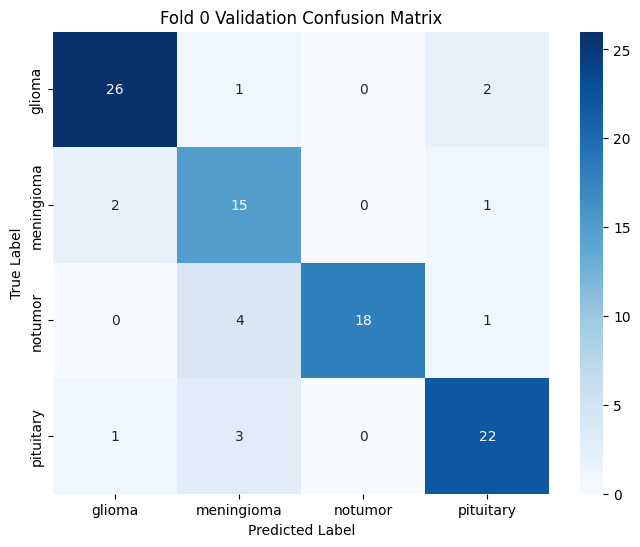

Classification Report for Fold 0:
              precision    recall  f1-score   support

      glioma       0.90      0.90      0.90        29
  meningioma       0.65      0.83      0.73        18
     notumor       1.00      0.78      0.88        23
   pituitary       0.85      0.85      0.85        26

    accuracy                           0.84        96
   macro avg       0.85      0.84      0.84        96
weighted avg       0.86      0.84      0.85        96

Class-wise TP, TN, FP, FN for Fold 0:
Class: glioma, TP: 26, TN: 64, FP: 3, FN: 3
Class: meningioma, TP: 15, TN: 70, FP: 8, FN: 3
Class: notumor, TP: 18, TN: 73, FP: 0, FN: 5
Class: pituitary, TP: 22, TN: 66, FP: 4, FN: 4
Loading model for fold 1...
Found 96 images belonging to 4 classes.
3/3 [==============================] - 2s 241ms/step
Fold 1 - AUC-ROC for class glioma: 0.9419
Fold 1 - AUC-ROC for class meningioma: 0.8654
Fold 1 - AUC-ROC for class notumor: 0.9292
Fold 1 - AUC-ROC for class pituitary: 0.9429


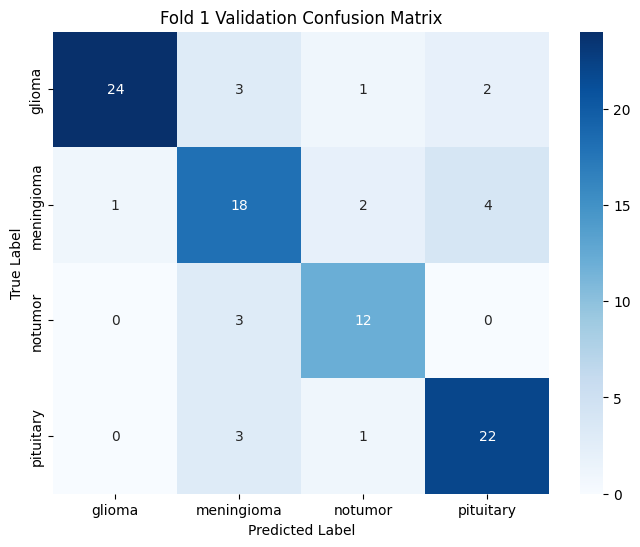

Classification Report for Fold 1:
              precision    recall  f1-score   support

      glioma       0.96      0.80      0.87        30
  meningioma       0.67      0.72      0.69        25
     notumor       0.75      0.80      0.77        15
   pituitary       0.79      0.85      0.81        26

    accuracy                           0.79        96
   macro avg       0.79      0.79      0.79        96
weighted avg       0.80      0.79      0.79        96

Class-wise TP, TN, FP, FN for Fold 1:
Class: glioma, TP: 24, TN: 65, FP: 1, FN: 6
Class: meningioma, TP: 18, TN: 62, FP: 9, FN: 7
Class: notumor, TP: 12, TN: 77, FP: 4, FN: 3
Class: pituitary, TP: 22, TN: 64, FP: 6, FN: 4
Loading model for fold 2...
Found 96 images belonging to 4 classes.
3/3 [==============================] - 2s 324ms/step
Fold 2 - AUC-ROC for class glioma: 0.9859
Fold 2 - AUC-ROC for class meningioma: 0.7956
Fold 2 - AUC-ROC for class notumor: 0.8944
Fold 2 - AUC-ROC for class pituitary: 0.9606


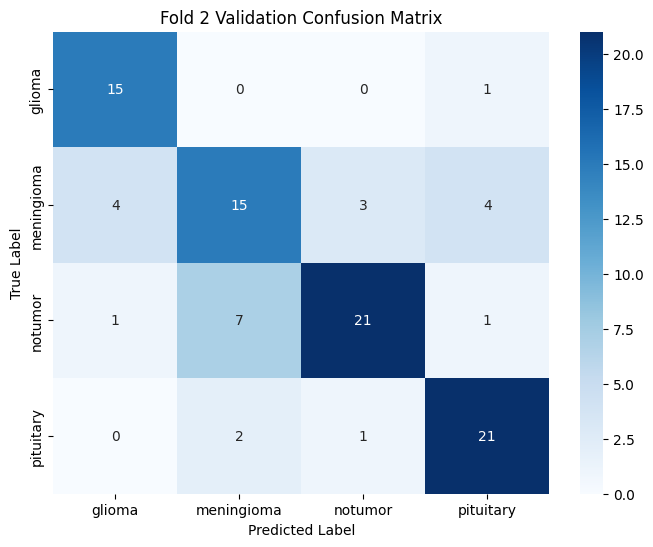

Classification Report for Fold 2:
              precision    recall  f1-score   support

      glioma       0.75      0.94      0.83        16
  meningioma       0.62      0.58      0.60        26
     notumor       0.84      0.70      0.76        30
   pituitary       0.78      0.88      0.82        24

    accuracy                           0.75        96
   macro avg       0.75      0.77      0.76        96
weighted avg       0.75      0.75      0.75        96

Class-wise TP, TN, FP, FN for Fold 2:
Class: glioma, TP: 15, TN: 75, FP: 5, FN: 1
Class: meningioma, TP: 15, TN: 61, FP: 9, FN: 11
Class: notumor, TP: 21, TN: 62, FP: 4, FN: 9
Class: pituitary, TP: 21, TN: 66, FP: 6, FN: 3
Loading model for fold 3...
Found 96 images belonging to 4 classes.
3/3 [==============================] - 2s 246ms/step
Fold 3 - AUC-ROC for class glioma: 0.9643
Fold 3 - AUC-ROC for class meningioma: 0.8361
Fold 3 - AUC-ROC for class notumor: 0.9545
Fold 3 - AUC-ROC for class pituitary: 0.9797


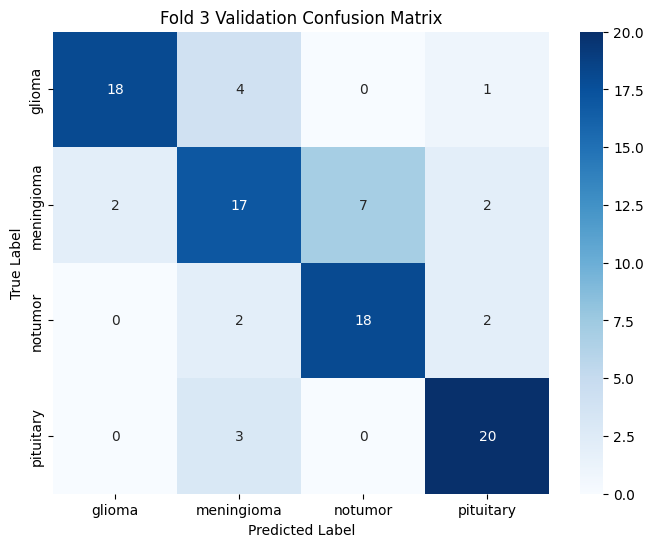

Classification Report for Fold 3:
              precision    recall  f1-score   support

      glioma       0.90      0.78      0.84        23
  meningioma       0.65      0.61      0.63        28
     notumor       0.72      0.82      0.77        22
   pituitary       0.80      0.87      0.83        23

    accuracy                           0.76        96
   macro avg       0.77      0.77      0.77        96
weighted avg       0.76      0.76      0.76        96

Class-wise TP, TN, FP, FN for Fold 3:
Class: glioma, TP: 18, TN: 71, FP: 2, FN: 5
Class: meningioma, TP: 17, TN: 59, FP: 9, FN: 11
Class: notumor, TP: 18, TN: 67, FP: 7, FN: 4
Class: pituitary, TP: 20, TN: 68, FP: 5, FN: 3
Loading model for fold 4...
Found 96 images belonging to 4 classes.
3/3 [==============================] - 3s 247ms/step
Fold 4 - AUC-ROC for class glioma: 0.9558
Fold 4 - AUC-ROC for class meningioma: 0.8183
Fold 4 - AUC-ROC for class notumor: 0.9788
Fold 4 - AUC-ROC for class pituitary: 0.9683


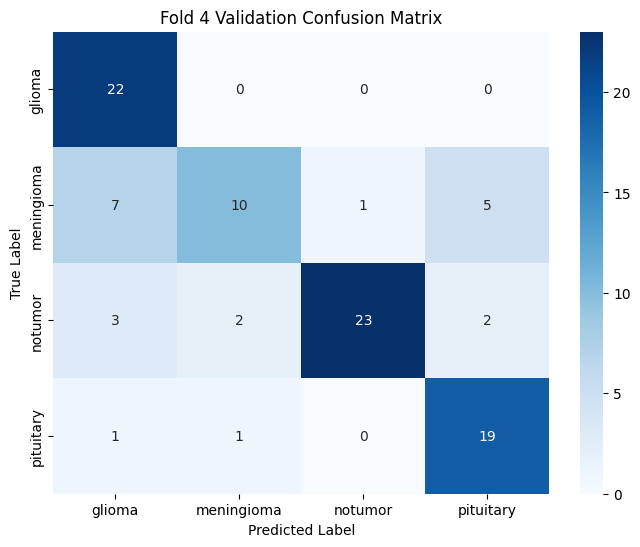

Classification Report for Fold 4:
              precision    recall  f1-score   support

      glioma       0.67      1.00      0.80        22
  meningioma       0.77      0.43      0.56        23
     notumor       0.96      0.77      0.85        30
   pituitary       0.73      0.90      0.81        21

    accuracy                           0.77        96
   macro avg       0.78      0.78      0.75        96
weighted avg       0.80      0.77      0.76        96

Class-wise TP, TN, FP, FN for Fold 4:
Class: glioma, TP: 22, TN: 63, FP: 11, FN: 0
Class: meningioma, TP: 10, TN: 70, FP: 3, FN: 13
Class: notumor, TP: 23, TN: 65, FP: 1, FN: 7
Class: pituitary, TP: 19, TN: 68, FP: 7, FN: 2


In [ ]:
# Confusion Matrix, AUC-ROC, and Classification Report for each fold
for fold in range(5):
    print(f'Loading model for fold {fold}...')
    model_path = f'/content/drive/MyDrive/CSC3009Project/efficientnetb0_fold_{fold}.h5'
    model = tf.keras.models.load_model(model_path)

    # Load the validation dataset for the current fold
    val_dir = os.path.join(base_dir, f'fold_{fold}', 'val')
    val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(224, 224),  # Image size specified here
        batch_size=32,
        class_mode='categorical',
        shuffle=False
    )

    # Make predictions on the validation data
    val_predictions = model.predict(val_generator)
    val_predictions_classes = np.argmax(val_predictions, axis=1)
    val_true_classes = val_generator.classes

    # Compute the confusion matrix for this fold
    val_conf_matrix = confusion_matrix(val_true_classes, val_predictions_classes)

    # Compute the AUC-ROC for each class
    val_true_classes_one_hot = tf.keras.utils.to_categorical(val_true_classes, num_classes)
    auc_roc_scores = {}
    for i, class_name in enumerate(val_generator.class_indices.keys()):
        fpr, tpr, _ = roc_curve(val_true_classes_one_hot[:, i], val_predictions[:, i])
        roc_auc = auc(fpr, tpr)
        auc_roc_scores[class_name] = roc_auc
        print(f'Fold {fold} - AUC-ROC for class {class_name}: {roc_auc:.4f}')

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(val_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=val_generator.class_indices.keys(), yticklabels=val_generator.class_indices.keys())
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Fold {fold} Validation Confusion Matrix')
    plt.show()

    # Print classification report for this fold
    print(f'Classification Report for Fold {fold}:')
    print(classification_report(val_true_classes, val_predictions_classes, target_names=list(val_generator.class_indices.keys())))

    # Calculate TP, TN, FP, FN for each class in this fold
    class_names = list(val_generator.class_indices.keys())
    table_data = []
    for i, class_name in enumerate(class_names):
        tp = val_conf_matrix[i, i]
        fp = np.sum(val_conf_matrix[:, i]) - tp
        fn = np.sum(val_conf_matrix[i, :]) - tp
        tn = np.sum(val_conf_matrix) - tp - fp - fn
        table_data.append([class_name, tp, tn, fp, fn])

    # Print the TP, TN, FP, FN table for this fold
    print(f"Class-wise TP, TN, FP, FN for Fold {fold}:")
    for row in table_data:
        print(f"Class: {row[0]}, TP: {row[1]}, TN: {row[2]}, FP: {row[3]}, FN: {row[4]}")


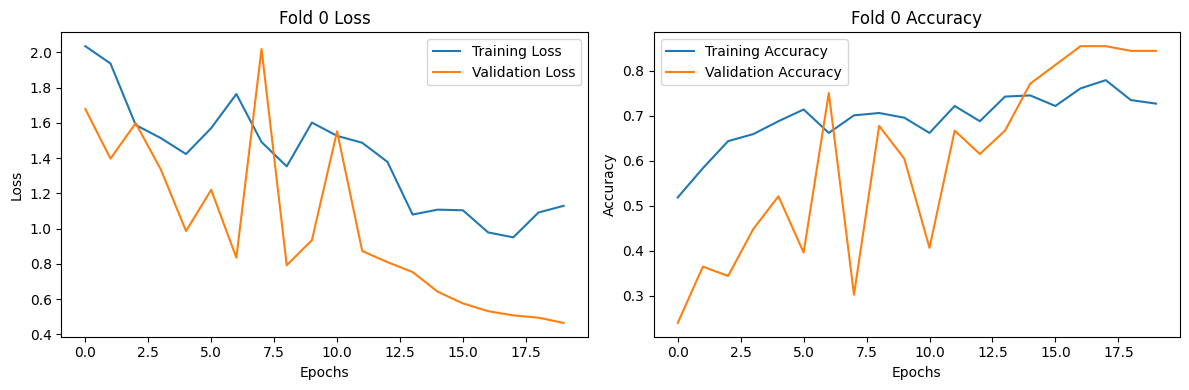

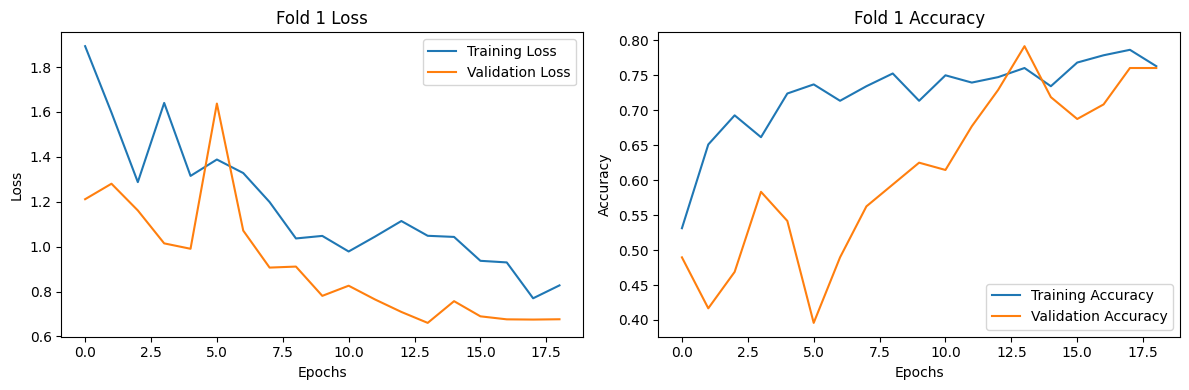

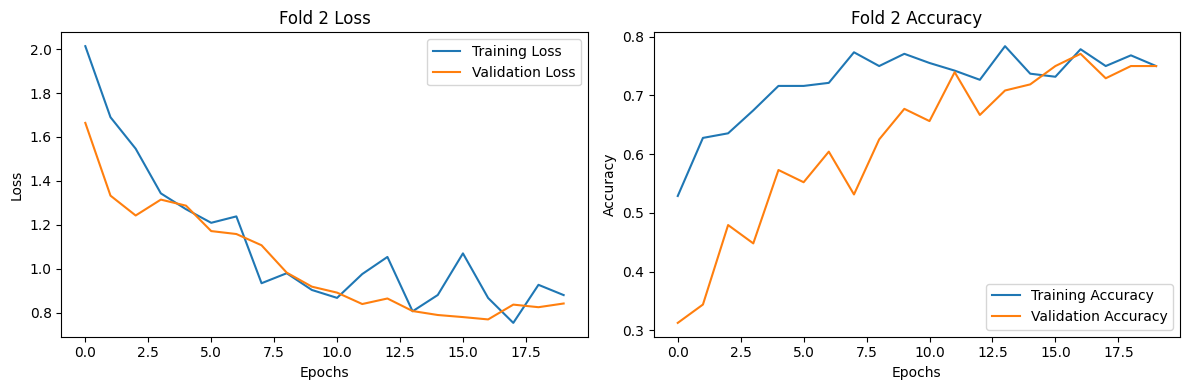

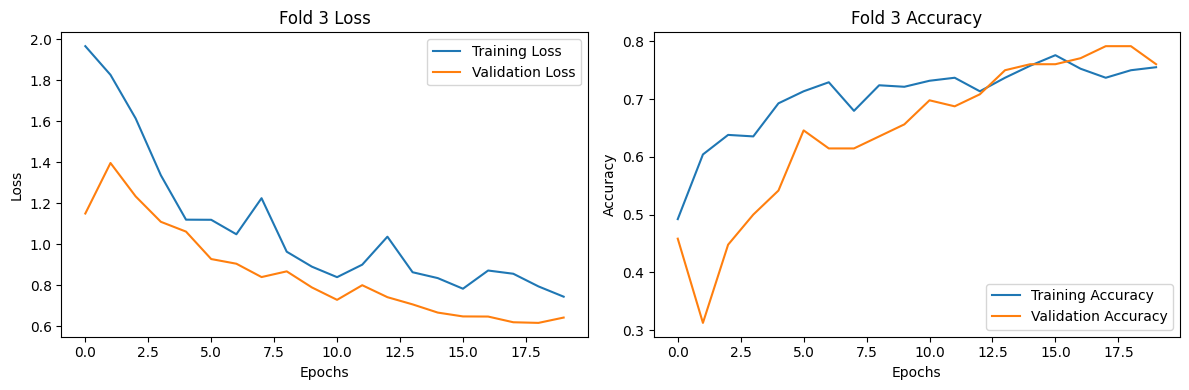

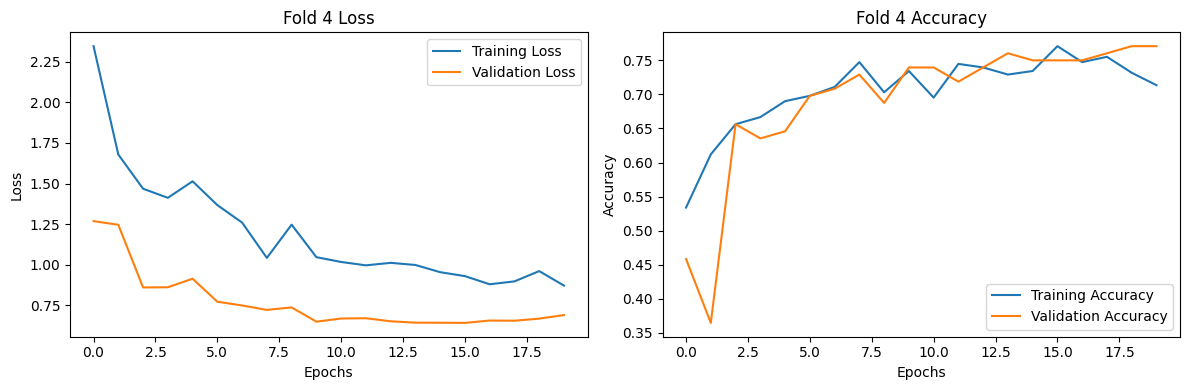

Accuracies for each fold:
Fold 0: 84.38%
Fold 1: 79.17%
Fold 2: 75.00%
Fold 3: 76.04%
Fold 4: 77.08%


In [ ]:
# Plotting Results and Printing Fold Accuracies
def plot_results(all_train_losses, all_val_losses, all_train_accuracies, all_val_accuracies):
    for fold in range(5):
        plt.figure(figsize=(12, 4))

        # Plot losses
        plt.subplot(1, 2, 1)
        plt.plot(all_train_losses[fold], label='Training Loss')
        plt.plot(all_val_losses[fold], label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title(f'Fold {fold} Loss')
        plt.legend()

        # Plot accuracies
        plt.subplot(1, 2, 2)
        plt.plot(all_train_accuracies[fold], label='Training Accuracy')
        plt.plot(all_val_accuracies[fold], label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title(f'Fold {fold} Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()

# Plot the results
plot_results(all_train_losses, all_val_losses, all_train_accuracies, all_val_accuracies)

# Print the accuracies for each fold
print("Accuracies for each fold:")
for fold, accuracy in enumerate(fold_accuracies):
    print(f"Fold {fold}: {accuracy * 100:.2f}%")


Make Prediction on Single Image

In [8]:
# Define the function to predict a random image
def predict_random_image(base_dir, model_path, target_size=(224, 224)):
    # Load the model
    model = load_model(model_path)

    # Get a list of all class directories
    class_dirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

    # Choose a random class directory
    random_class = random.choice(class_dirs)
    random_class_dir = os.path.join(base_dir, random_class)

    # Get a list of all images in the chosen class directory
    image_files = [f for f in os.listdir(random_class_dir) if f.endswith(('jpg', 'png', 'jpeg'))]

    # Choose a random image file
    random_image_file = random.choice(image_files)
    random_image_path = os.path.join(random_class_dir, random_image_file)

    # Load and preprocess the image
    img = load_img(random_image_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Normalize the image
    img_array -= mean
    img_array /= std

    # Predict the class of the image
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]

    # Get the class labels
    class_labels = {v: k for k, v in val_generator.class_indices.items()}
    predicted_label = class_labels[predicted_class]

    # Display the image with predicted and true labels
    plt.imshow(img)
    plt.title(f"True: {random_class}, Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()

# Base directory containing the dataset
base_dir = '/content/drive/MyDrive/CSC3009Project/dataset_kfold/fold_0/val'

# Path to the saved model from fold 0
model_path = '/content/drive/MyDrive/CSC3009Project/efficientnetb0_fold_0.h5'


Found 96 images belonging to 4 classes.
1/1 [==============================] - 1s 1s/step


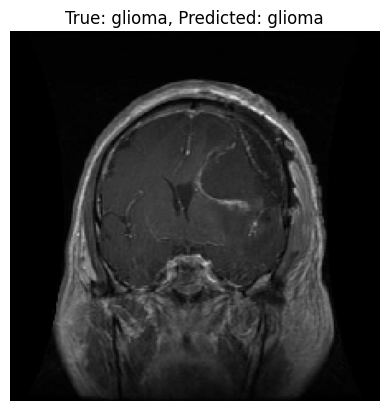

In [11]:
val_dir='/content/drive/MyDrive/CSC3009Project/dataset_kfold/fold_0/val'

val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(224, 224),  # Image size specified here
        batch_size=32,
        class_mode='categorical',
        shuffle=False
    )

# Predict and display a random image
predict_random_image(base_dir, model_path, target_size=(224, 224))